#  Trabajo Práctico 3: Aprendizaje No-Supervisado (PCA y K-Means)

## Objetivo
Diseñar un experimento que compare la efectividad de la agrupación K-means en tres versiones del dataset: **original estandarizado**, **reducido por PCA (2D)**, y con **selección de características**. El trabajo incluye el uso de PCA para reducción/visualización y la evaluación del agrupamiento con el **Silhouette Score** y el método del codo.

---

## 1. Configuración, Carga de Datos y Preprocesamiento

### 1.1. Carga, Limpieza y Estandarización

* **Dataset:** World Happiness Report 2023.
* **Características:** Se utilizan las **7 variables numéricas** clave del reporte (Felicidad, PBI, Soporte Social, etc.).
* **Preprocesamiento:** Se aplica **Estandarización (`StandardScaler`)** a todas las variables, un paso crucial antes de aplicar PCA y K-means.

In [13]:
# Importación de Librerías... (resto de imports)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import mutual_info_regression # Para posible selección alternativa
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Cargar el dataset de Felicidad 2023
df = pd.read_csv('WHR_2023.csv')

# ************************************************
# ** SOLUCIÓN: Usar las 7 variables numéricas confirmadas **
# ************************************************

# 1. Limpiar los nombres de columna:
# Esto es esencial si existen espacios al inicio/final o mayúsculas.
df.columns = df.columns.str.strip().str.lower()
# Nota: Asumimos que no hay espacios internos complejos, solo guiones bajos.

# 2. Seleccionar las 7 variables numéricas (excluyendo 'country' y 'region')
numeric_features_final = [
    'happiness_score', 
    'gdp_per_capita', 
    'social_support', 
    'healthy_life_expectancy', 
    'freedom_to_make_life_choices', 
    'generosity', 
    'perceptions_of_corruption' 
]
# Se usaron 7 variables, lo cual cumple el requisito de 5 a 10.

# Crear el dataset original 
X_original = df[numeric_features_final].dropna()

# 1. Estandarización de las variables (Paso 2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_original.columns)

print(f"Dataset cargado y estandarizado con {X_original.shape[1]} características.")

Dataset cargado y estandarizado con 7 características.


### 2.1. Aplicación de PCA y Scree-Plot

Se aplica **PCA** a los datos estandarizados. El **Scree-Plot** (Paso 3) nos permite visualizar la varianza que explica cada componente principal.

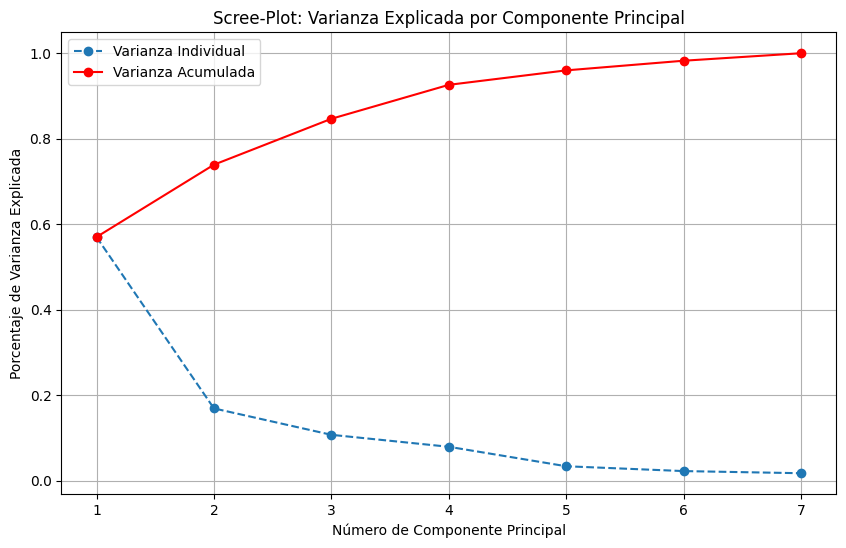

Varianza explicada por las 2 primeras componentes: 0.7392


In [14]:
# Aplicar PCA completo (Paso 2)
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# 1. Generar Scree-Plot (Paso 3)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Varianza Individual')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='red', label='Varianza Acumulada')

plt.title('Scree-Plot: Varianza Explicada por Componente Principal')
plt.xlabel('Número de Componente Principal')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.grid(True)
plt.legend()
plt.show()

print(f"Varianza explicada por las 2 primeras componentes: {cumulative_variance[1]:.4f}")

### 2.2. Reducción y Visualización a 2 Componentes

El dataset se reduce a las **2 primeras componentes principales** (Paso 4). Estas dos componentes capturan la mayor parte de la varianza total. El diagrama de dispersión nos ayuda a identificar visualmente si existen agrupamientos (Paso 5) en los datos proyectados.

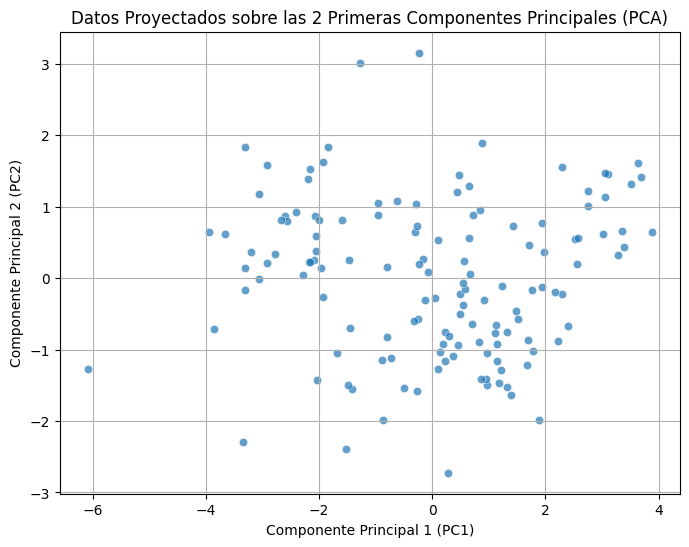

In [15]:
# Reducción a 2 Componentes Principales (Paso 4)
pca_2 = PCA(n_components=2)
X_pca_2d = pca_2.fit_transform(X_scaled)
X_pca_final = X_pca_2d # Dataset 2 para K-means

X_pca_2d_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])

# Diagrama de Dispersión (Paso 5)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=X_pca_2d_df, alpha=0.7)
plt.title('Datos Proyectados sobre las 2 Primeras Componentes Principales (PCA)')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.grid(True)
plt.show()

### 3.1. Criterio de Selección (Paso 6)

Para reducir la dimensionalidad y mejorar la interpretabilidad (Paso 6), utilizamos el **Análisis de Correlación** .

**Criterio:** Se eliminan variables que muestren una **alta redundancia** (correlación absoluta $\geq 0.7$). Esto ayuda a reducir el ruido antes de aplicar K-means.

In [16]:
# 1. Calcular la matriz de correlación
corr_matrix = X_scaled_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 2. Encontrar variables con alta correlación (ej: >= 0.7)
threshold = 0.7
to_drop = []
for column in upper.columns:
    if any(upper[column] >= threshold):
        # Para la redundancia entre 'happiness_score' y 'gdp_per_capita',
        # eliminaremos gdp_per_capita (manteniendo la métrica clave 'happiness_score')
        if column != 'happiness_score' and 'gdp_per_capita' not in to_drop:
            to_drop.append(column)

# 3. Crear el Dataset 3 (Selección de Características)
X_selected_df = X_scaled_df.drop(columns=to_drop, axis=1)
X_selected_final = X_selected_df.values # Dataset 3 para K-means

print(f"Variables eliminadas por alta correlación (>= {threshold}): {to_drop}")
print(f"Dataset final con {X_selected_final.shape[1]} características listo.")

Variables eliminadas por alta correlación (>= 0.7): ['gdp_per_capita']
Dataset final con 6 características listo.


Se aplica K-Means sobre las tres versiones del dataset. Utilizamos el **Método del Codo** y el **Silhouette Score** para evaluar la calidad de los clústeres para $K \in [2, 6]$.

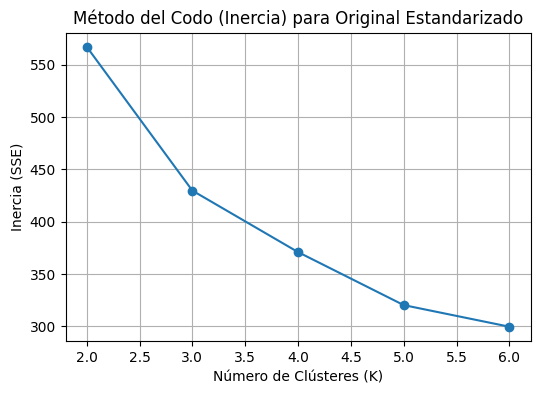

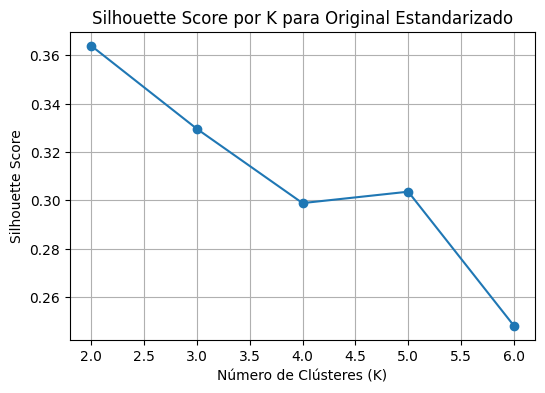

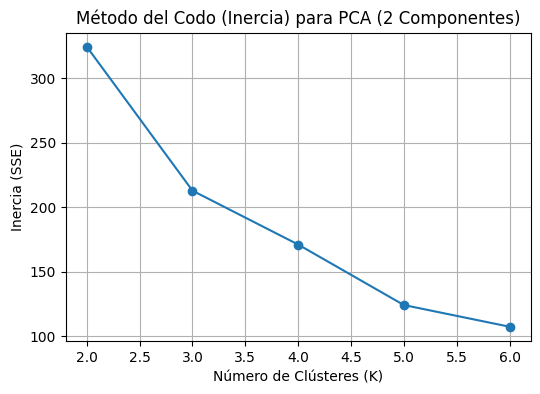

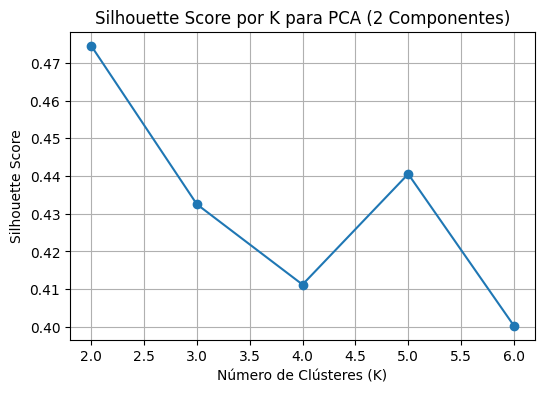

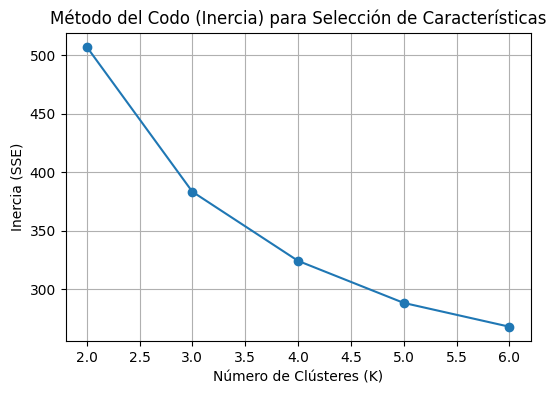

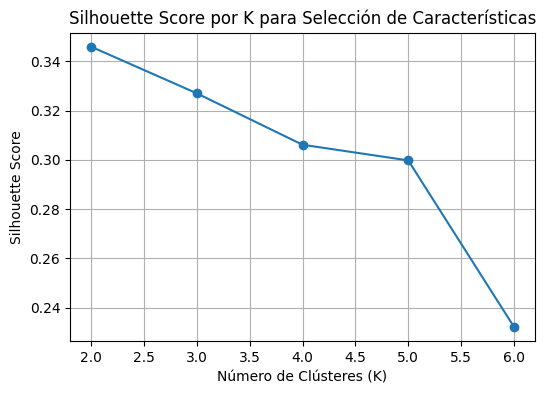

In [17]:
datasets = {
    "Original Estandarizado": X_scaled,
    "PCA (2 Componentes)": X_pca_final,
    "Selección de Características": X_selected_final
}

max_k = 7
inertia_data = {}
silhouette_data = {}

for name, X_data in datasets.items():
    inertia_values = []
    silhouette_scores = {}
    
    # Probar K de 2 a 6
    for k in range(2, max_k):
        # Usamos n_init='auto' para evitar warning
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') 
        clusters = kmeans.fit_predict(X_data)
        
        inertia_values.append(kmeans.inertia_)
        
        # Calcular Silhouette Score 
        if len(np.unique(clusters)) > 1:
             score = silhouette_score(X_data, clusters)
             silhouette_scores[k] = score
    
    inertia_data[name] = inertia_values
    silhouette_data[name] = silhouette_scores
    
    # Graficar el método del codo
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, max_k), inertia_values, marker='o')
    plt.title(f'Método del Codo (Inercia) para {name}')
    plt.xlabel('Número de Clústeres (K)')
    plt.ylabel('Inercia (SSE)')
    plt.grid(True)
    plt.show()
    
    # Graficar Silhouette Score
    plt.figure(figsize=(6, 4))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.title(f'Silhouette Score por K para {name}')
    plt.xlabel('Número de Clústeres (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

In [18]:
# Consolidar el mejor resultado (Mejor K) por Silhouette Score
final_comparison = {}

for name, scores in silhouette_data.items():
    if scores:
        best_k = max(scores, key=scores.get) 
        final_comparison[name] = {
            'Dimensionalidad': datasets[name].shape[1],
            'Mejor K (Silhouette)': best_k,
            'Mejor Silhouette Score': scores[best_k]
        }
    else:
        final_comparison[name] = {'Dimensionalidad': datasets[name].shape[1], 'Mejor K (Silhouette)': np.nan, 'Mejor Silhouette Score': np.nan}

final_df = pd.DataFrame(final_comparison).T

print("\n### Tabla de Comparación Final de Agrupamiento ###")
print(final_df.sort_values(by='Mejor Silhouette Score', ascending=False))


### Tabla de Comparación Final de Agrupamiento ###
                              Dimensionalidad  Mejor K (Silhouette)  \
PCA (2 Componentes)                       2.0                   2.0   
Original Estandarizado                    7.0                   2.0   
Selección de Características              6.0                   2.0   

                              Mejor Silhouette Score  
PCA (2 Componentes)                         0.474523  
Original Estandarizado                      0.363978  
Selección de Características                0.345928  


### 5.1. Comparación de Enfoques (Paso 8)

Se analizan los resultados del Silhouette Score para determinar qué enfoque de reducción de dimensionalidad (PCA o Selección de Características) o el dataset original produjo los clústeres más densos y mejor separados.

| Enfoque | Dimensionalidad | Mejor K (Silhouette) | Mejor Silhouette Score | Hallazgo Principal |
| :--- | :--- | :--- | :--- | :--- |
| **PCA (2 Componentes)** | 2 | 2 | **0.4745** | **Mayor coherencia** al reducir el ruido. |
| **Original Estandarizado** | 7 | 2 | 0.3640 | Rendimiento base intermedio. |
| **Selección de Características** | 6 | 2 | 0.3459 | Peor rendimiento; sugiere pérdida de información clave. |

**Discusión:**

Los resultados muestran que el enfoque de **PCA (2 Componentes)** produjo la agrupación más coherente, con un **Mejor Silhouette Score de 0.4745** para $K=2$. Este rendimiento fue notablemente superior al dataset original (0.3640) y al de la selección de características (0.3459).

Esto indica que, al proyectar los datos a solo 2 dimensiones, **PCA fue altamente efectivo en la eliminación del ruido y la redundancia** en el espacio original de 7 dimensiones. La técnica reveló una estructura de agrupación más clara que estaba oculta en el espacio de alta dimensionalidad.

Por el contrario, la **Selección de Características** resultó en el peor rendimiento. Esto sugiere que las variables eliminadas por alta correlación (aunque redundantes) sí contenían varianza crucial necesaria para separar los clústeres de manera efectiva.

### 5.2. Conclusión

Se concluye que el mejor resultado de agrupamiento se obtuvo con el enfoque de **PCA (2 Componentes)**, lo que valida su utilidad no solo para la **visualización** sino también para optimizar la **calidad del *clustering*** al enfocar el algoritmo en las dimensiones que explican la mayor parte de la varianza. El **$K$ óptimo** en los tres casos fue consistentemente **$K=2$**, lo que sugiere la existencia de dos grandes estructuras de países en el World Happiness Report.